Import The Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats

The code below:
1. Read the data from the file in the directory into dataframe
2. Split the data into train and test while maintaining the proportion
3. Remove features which have half of their data missing (50%)
4. Drop Constant Columns --> Variance 0

In [ ]:


df = pd.read_csv("C:/Users/SpoorthiRanganath/Desktop/SECOM/secom_data.csv")
df = df.drop(columns=['Timestamp'])

X = df.drop(columns=['Pass/Fail'])
y = df['Pass/Fail']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
train_proportion = y_train.value_counts(normalize=True)
test_proportion = y_test.value_counts(normalize=True)

(train_proportion, test_proportion)

missing_values_percent = X_train.isna().mean() * 100
threshold = 50
columns_to_keep = missing_values_percent[missing_values_percent <= threshold].index

X_train_filtered = X_train[columns_to_keep]
X_test_filtered = X_test[columns_to_keep]
num_columns_removed = X_train.shape[1] - X_train_filtered.shape[1]
remaining_columns = X_train_filtered.shape[1]

num_columns_removed, remaining_columns

zero_variance_cols = X_train_filtered.columns[X_train_filtered.nunique() <= 1]
X_train_filtered = X_train_filtered.drop(columns=zero_variance_cols)
X_test_filtered = X_test_filtered.drop(columns=zero_variance_cols)
print("Columns with zero variance removed:", zero_variance_cols.tolist())
print("Updated number of columns in training data:", X_train_filtered.shape[1])

Columns with zero variance removed: ['Feature_6', 'Feature_14', 'Feature_43', 'Feature_50', 'Feature_53', 'Feature_70', 'Feature_98', 'Feature_142', 'Feature_150', 'Feature_179', 'Feature_180', 'Feature_187', 'Feature_190', 'Feature_191', 'Feature_192', 'Feature_193', 'Feature_194', 'Feature_195', 'Feature_227', 'Feature_230', 'Feature_231', 'Feature_232', 'Feature_233', 'Feature_234', 'Feature_235', 'Feature_236', 'Feature_237', 'Feature_238', 'Feature_241', 'Feature_242', 'Feature_243', 'Feature_244', 'Feature_257', 'Feature_258', 'Feature_259', 'Feature_260', 'Feature_261', 'Feature_262', 'Feature_263', 'Feature_264', 'Feature_265', 'Feature_266', 'Feature_267', 'Feature_277', 'Feature_285', 'Feature_314', 'Feature_315', 'Feature_316', 'Feature_323', 'Feature_326', 'Feature_327', 'Feature_328', 'Feature_329', 'Feature_330', 'Feature_331', 'Feature_365', 'Feature_370', 'Feature_371', 'Feature_372', 'Feature_373', 'Feature_374', 'Feature_375', 'Feature_376', 'Feature_379', 'Feature_38

Outlier Handling:
1. Identify Outliers Using Z score
2. Mask them as a missing value NaN

In [ ]:
z_scores_train = np.abs(stats.zscore(X_train_filtered.select_dtypes(include=[np.number])))

outlier_threshold = 3
outliers_mask_train = (z_scores_train > outlier_threshold).any(axis=1)

print(f"Total outliers detected in training data: {outliers_mask_train.sum()}")



X_train_filtered.loc[outliers_mask_train, X_train_filtered.select_dtypes(include=[np.number]).columns] = np.nan

Total outliers detected in training data: 462


KNN IMPUTATION
Respective Comments have been added in the code

In [ ]:
# Initializing the scaler and imputer
scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=3)

preprocessor = Pipeline(steps=[
    ('scaler', scaler),
    ('imputer', imputer)
])

# Fitting the preprocessor on the training and testing data and transforming
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert the processed arrays back to DataFrames so that they can be accessed easily later
X_train_processed = pd.DataFrame(X_train_processed, columns=X_train.columns)
X_test_processed = pd.DataFrame(X_test_processed, columns=X_test.columns)

Feature Selection -- RFE followed by Boruta

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE


X = X_train_processed
y = y_train

# Initialize and fit the Random Forest classifier
classifier = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
rfe = RFE(estimator=classifier, n_features_to_select=10, step=1)
rfe.fit(X, y)

selected_features_rfe = pd.Series(rfe.support_, index=X_train.columns)
print("Selected Features:")
print(selected_features_rfe[selected_features_rfe == True].index.tolist())

Selected Features:
['Feature_32', 'Feature_34', 'Feature_60', 'Feature_82', 'Feature_104', 'Feature_131', 'Feature_184', 'Feature_248', 'Feature_320', 'Feature_478']


C:\Users\SpoorthiRanganath\AppData\Local\Temp\ipykernel_10348\362950370.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')


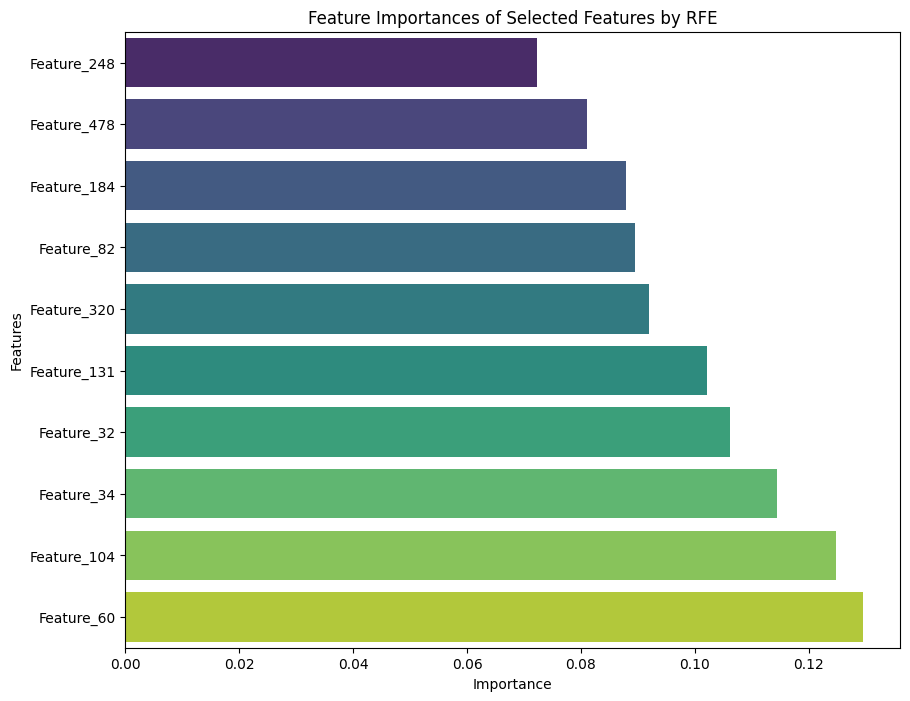

In [ ]:
selected_features_mask = rfe.support_
selected_feature_names = X_train_processed.columns[selected_features_mask]

# Refit the classifier on just the selected features
X_selected_rfe = X_train_processed[selected_feature_names]
classifier.fit(X_selected_rfe, y_train)

# Extract feature importances
feature_importances = classifier.feature_importances_

# Create a DataFrame for feature importances for visualization
features_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title('Feature Importances of Selected Features by RFE')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


Feature Selection by BORUTA

In [ ]:
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42)

boruta_selector.fit(X_train_processed.values, y_train)

selected_features_boruta = X_train_processed.columns[boruta_selector.support_].tolist()
print("Selected Features by Boruta:")
print(selected_features_boruta)

Selected Features by Boruta:
['Feature_32', 'Feature_34', 'Feature_60', 'Feature_65', 'Feature_66', 'Feature_104', 'Feature_122', 'Feature_131', 'Feature_214', 'Feature_352', 'Feature_478', 'Feature_520']


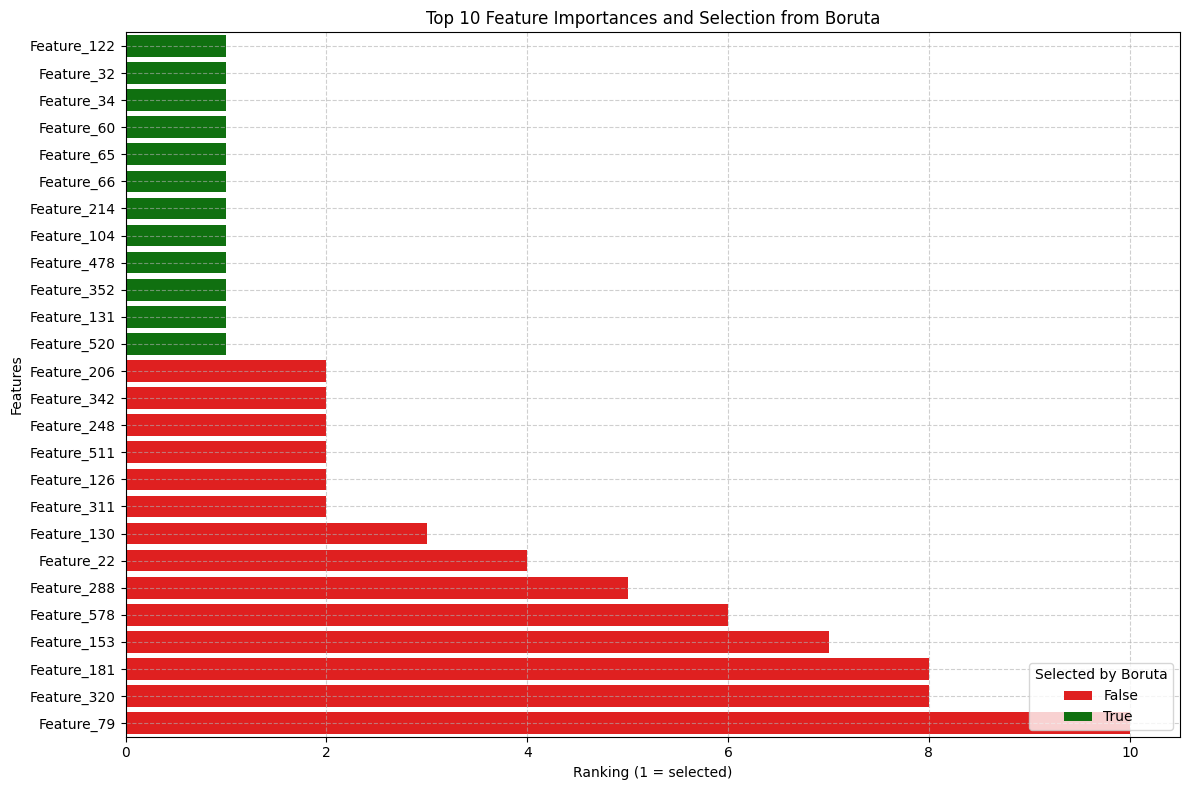

In [ ]:
rankings = boruta_selector.ranking_#ranking
selected_mask = boruta_selector.support_

features = X_train_processed.columns
feature_importances = pd.DataFrame({
    'feature': features,
    'ranking': rankings,
    'selected': selected_mask
})

feature_importances = feature_importances[feature_importances['ranking'] <= 10]

feature_importances.sort_values(by='ranking', inplace=True)


plt.figure(figsize=(12, 8))  # Adjust size as necessary
sns.barplot(x='ranking', y='feature', data=feature_importances, hue='selected', dodge=False, palette={True: 'green', False: 'red'})
plt.title('Top 10 Feature Importances and Selection from Boruta')
plt.xlabel('Ranking (1 = selected)')
plt.ylabel('Features')
plt.legend(title='Selected by Boruta', loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
x_train_rfe = X_train_processed[selected_features_rfe]
x_test_rfe = X_test_processed[selected_features_rfe]


In [ ]:
x_train_boruta = X_train_processed[selected_features_boruta]
x_test_boruta = X_test_processed[selected_features_boruta]

Handling Imbalance and passing the selected features by RFE

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled1, y_train_resampled1 = smote.fit_resample(X_selected_rfe, y_train)

In [ ]:
rf = RandomForestClassifier(n_estimators=6000, random_state=42)
rf.fit(X_train_resampled1, y_train_resampled1)


RandomForestClassifier(n_estimators=6000, random_state=42)

In [ ]:
x_test_rfe = X_test_processed[selected_feature_names]

In [ ]:
X_selected_rfe = X_train_processed[selected_feature_names]
X_selected_rfe.head()

,Feature_32,Feature_34,Feature_60,Feature_82,Feature_104,Feature_131,Feature_184,Feature_248,Feature_320,Feature_478
0,-0.517122,-0.440317,1.322974,-0.203448,1.383600,1.042653,0.703030,-0.053059,0.982068,-0.021040
1,1.834620,-0.219786,-0.151566,0.085085,-0.272612,-0.032035,-0.050127,-0.526789,0.333937,-0.168541
2,-0.626697,-0.127077,2.984438,0.797207,1.582345,0.000277,1.296383,1.305169,1.309560,1.053007
3,-0.635859,-0.312944,-0.331339,0.238559,-0.603854,-0.937981,0.312318,-0.475818,0.296677,0.428262
4,-0.547601,-0.139104,-0.073307,0.011417,-0.802600,0.001474,0.261982,0.365703,0.319914,-0.233254


In [ ]:
y_pred = rf.predict(x_test_rfe)

# Use metrics to evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(x_test_rfe)[:, 1]))

              precision    recall  f1-score   support

          -1       0.93      0.94      0.94       366
           1       0.08      0.08      0.08        26

    accuracy                           0.88       392
   macro avg       0.51      0.51      0.51       392
weighted avg       0.88      0.88      0.88       392

Confusion Matrix:
 [[344  22]
 [ 24   2]]
ROC AUC Score: 0.6943568726355612


Handling Imbalance and Passing the Features Selected by Boruta

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled2, y_train_resampled2 = smote.fit_resample(x_train_boruta, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled2, y_train_resampled2)

RandomForestClassifier(random_state=42)

In [ ]:

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(x_train_boruta, y_train)


final_rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)
final_rf.fit(X_train_smote, y_train_smote)
y_pred = final_rf.predict(x_test_boruta)
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))




              precision    recall  f1-score   support

          -1       0.94      0.96      0.95       366
           1       0.20      0.15      0.17        26

    accuracy                           0.90       392
   macro avg       0.57      0.56      0.56       392
weighted avg       0.89      0.90      0.90       392

Confusion Matrix:
[[350  16]
 [ 22   4]]


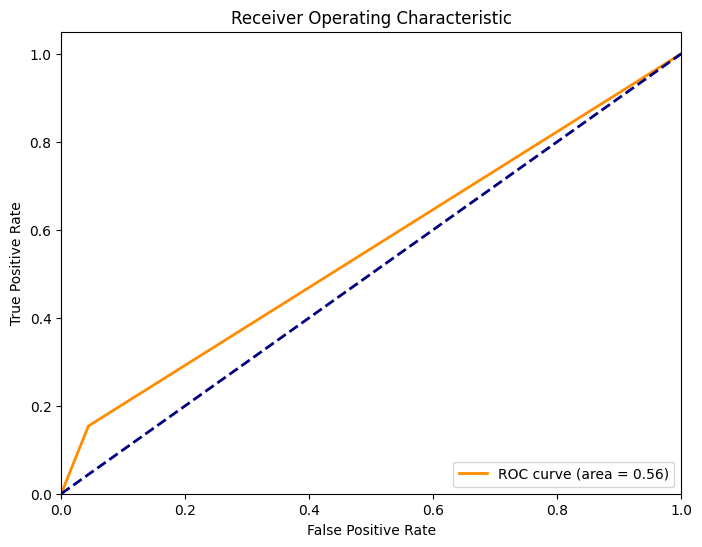

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

#probabilities = final_rf.predict_proba(x_test_boruta)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()